# Working with different grids

Before duing any calculations is importat to think what is the end goal and choose the apropiate zoom (if available). For example, if you want to compare a UM similation with ERA5 you will probably need to regrid the model output to ERA5 grid and resolution. In this case, using `zoom = 6` or `7` for the model will be the closest to ERA5 resolution and will make calculations more efficient. 

In [1]:
import xarray as xr
import healpy as hp
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

## Reading the UM model output

Let's work with a 2D field, for example surface temperature. 

In [2]:
zoom = '7'
file = '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z' + zoom + '.zarr'

ds2d = xr.open_zarr(file)
ds2d

<xarray.Dataset> Size: 198GB
Dimensions:  (cell: 196608, time: 10489)
Coordinates:
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    crs      float64 8B ...
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
Data variables: (12/24)
    clivi    (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    clt      (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    clwvi    (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    hflsd    (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    hfssd    (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    huss     (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    ...       ...
    rsut     (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    rsutcs   (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    tas      (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    ts       (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    uas      (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    vas      (time, cell) float32 8GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n2560_RAL3p3
    simulation_description:           The MetUM uses a regular lat-lon grid, ...

Text(0.5, 1.0, 'UM Surface temperature 2020-01-26T00:00:00 HEALPix Zoom 7')

<Figure size 640x480 with 0 Axes>

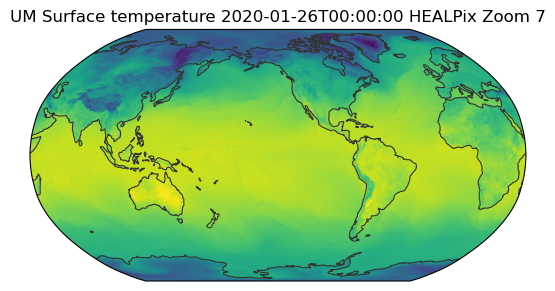

In [3]:
tas_um = ds2d['tas'] #temperature near surface

this_time = '2020-01-26T00:00:00'
egh.healpix_show(tas_um.sel(time = this_time).squeeze(), cmap = 'viridis')
plt.title('UM Surface temperature ' + this_time + ' HEALPix Zoom '+ zoom)

We've read the variable and ploted the first available time but usually we sometime analyse temperature averaged over time. Let's try to calculate the monthly average for temperature. 

Text(0.5, 1.0, 'UM monthly surface temperature for February - HEALPix Zoom 7')

<Figure size 640x480 with 0 Axes>

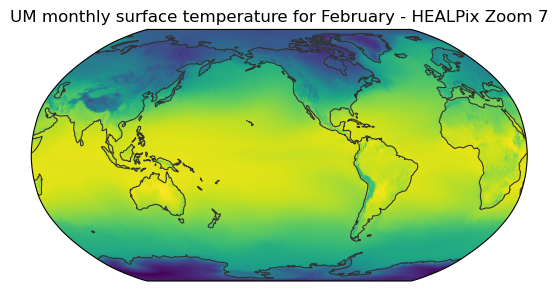

In [4]:
tas_um_month = tas_um.groupby("time.month").mean() # Calculate monthly mean.

this_month = 2
egh.healpix_show(tas_um_month.sel(month = this_month).squeeze(), cmap = 'viridis')
plt.title('UM monthly surface temperature for February - HEALPix Zoom '+ zoom)

## Reading ERA5

Now we are reading ERA5 surface temperature to compare with the simulation. In this case, we have the temperature at 2m (`t2m`) and this may not be exactly the same as "surface temperature" for UM, you will need to check the model documentation to decide if the comparison is scientifically correct. In any case, the example is useful to see how the code works.

In [5]:
import xarray as xr

# Step 1: Load multiple NetCDF files along the time dimension
file_era5 = '/g/data/rt52/era5/single-levels/reanalysis/2t/2020/2t_era5_oper_sfc_*.nc'
tas_era = xr.open_mfdataset(file_era5, combine='nested', concat_dim='time')

# Step 2: Compute monthly mean of 2m temperature
tas_era_monthly = tas_era['t2m'].groupby('time.month').mean()

# Step 3: Convert longitude from [-180, 180] to [0, 360]
tas_era_monthly = tas_era_monthly.assign_coords(
    longitude=(tas_era_monthly.longitude % 360)
).sortby('longitude')


In [6]:
print(tas_era_monthly.longitude.values)


[0.0000e+00 2.5000e-01 5.0000e-01 ... 3.5925e+02 3.5950e+02 3.5975e+02]


In [7]:
tas_era_monthly

<xarray.DataArray 't2m' (month: 12, latitude: 721, longitude: 1440)> Size: 100MB
dask.array<getitem, shape=(12, 721, 1440), dtype=float64, chunksize=(1, 91, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Attributes:
    units:      K
    long_name:  2 metre temperature

Text(0.5, 1.0, 'ERA5 surface temperature for February 2020')

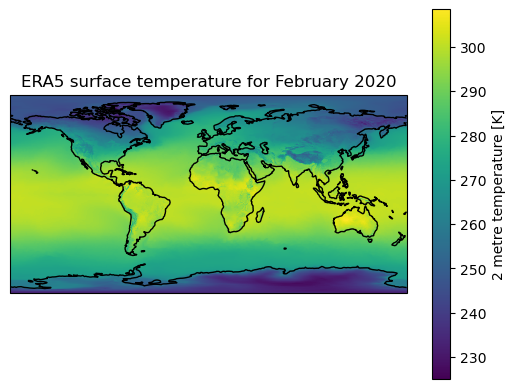

In [8]:
projection = ccrs.PlateCarree(central_longitude = 0.0)

fig, ax = plt.subplots(subplot_kw = {"projection": projection})
tas_era_monthly.sel(month = 2).plot(cmap = 'viridis', transform = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('ERA5 surface temperature for February 2020')

## Regriding

Now that we have read the 2 dataset we want to compare them and for that, they need to be in the same grid. We'll do this only for Australia region as the regriding can take some time depending on the resolution. 

In [9]:
tas_era_monthly_aus = tas_era_monthly.sel(
    longitude=slice(140, 220),   # 140°E to 140°W
    latitude=slice(10, -30)      # 10°N to 30°S if latitudes are descending
)

tas_era_monthly_aus

<xarray.DataArray 't2m' (month: 12, latitude: 161, longitude: 321)> Size: 5MB
dask.array<getitem, shape=(12, 161, 321), dtype=float64, chunksize=(1, 91, 161), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 644B 10.0 9.75 9.5 9.25 ... -29.5 -29.75 -30.0
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * longitude  (longitude) float32 1kB 140.0 140.2 140.5 ... 219.5 219.8 220.0
Attributes:
    units:      K
    long_name:  2 metre temperature

For the regriding we are using the [`ang2pix()`](https://healpy.readthedocs.io/en/latest/generated/healpy.pixelfunc.ang2pix.html#healpy.pixelfunc.ang2pix) function that given a `nside` number (directly related to the resolution and number of cells) and a grid in lon/lat, it returns an array with the cell indexes in the healpix grid for the lon/lat grid.

In [10]:

def get_nn_lon_lat_index(nside, lons, lats):
    """
    nside: integer, power of 2. The return of hp.get_nside()
    lons: uniques values of longitudes
    lats: uniques values of latitudes
    returns: array with the HEALPix cells that are closest to the lon/lat grid
    """
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest = True, lonlat = True),
        coords=[("lat", lats), ("lon", lons)],
    )


In [11]:
# Find the HEALPix pixels that are closest to the ERA5 grid

# longitudes and latitudes for the ERA5 grid
lon = tas_era_monthly_aus['longitude'].values
lat = tas_era_monthly_aus['latitude'].values

# nside for um simulation, it should be equal to 2**zoom
this_nside = hp.get_nside(tas_um_month)

cells = get_nn_lon_lat_index(this_nside, lon, lat) 

cells

<xarray.DataArray (lat: 161, lon: 321)> Size: 413kB
array([[ 16791,  16834,  16832, ...,  33472,  33473,  33387],
       [ 16791,  16789,  16832, ...,  33472,  33386,  33387],
       [ 16788,  16789,  16789, ...,  33386,  33386,  33384],
       ...,
       [160151, 160194, 160192, ..., 176832, 176833, 176747],
       [160151, 160149, 160192, ..., 176832, 176746, 176747],
       [160149, 160149, 160149, ..., 176746, 176746, 176746]],
      shape=(161, 321))
Coordinates:
  * lat      (lat) float32 644B 10.0 9.75 9.5 9.25 ... -29.25 -29.5 -29.75 -30.0
  * lon      (lon) float32 1kB 140.0 140.2 140.5 140.8 ... 219.5 219.8 220.0

The `cells` array can now be used to resample the UM data to choose one cell per lon/lat grid point. This array is (181,221), exactly the same shape as the ERA5 subset for Australia `tas_era_monthly_aus`.

Text(0.5, 1.0, 'UM surface temperature for February 2020')

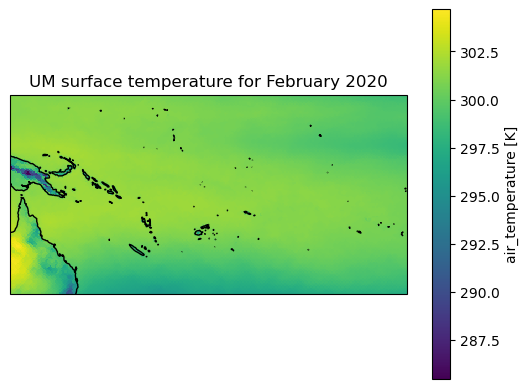

In [15]:
# Set the projection centered on 180°
projection = ccrs.PlateCarree(central_longitude=180)

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": projection})
tas_um_month.isel(cell=cells).sel(month=2).plot(
    cmap='viridis',
    transform=ccrs.PlateCarree(),  # data is in regular lat/lon
    ax=ax
)

ax.coastlines()
ax.set_title('UM surface temperature for February 2020')


Now we can calculate the difference, note that ERA5 is in meters and UM is in milimiters. 

In [16]:
tas_um_month_regrided = tas_um_month.isel(cell = cells) # regriding
tas_um_month_regrided = tas_um_month_regrided.rename({'lon': 'longitude', 'lat': 'latitude'}) # we need to change the names to match ERA5 data


Text(0.5, 1.0, 'Difference UM - ERA5, surface temperature 02/2020')

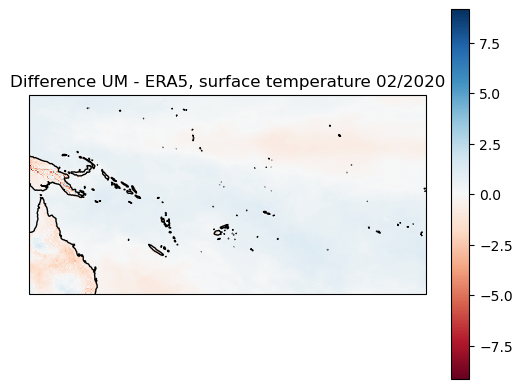

In [17]:
difference = tas_um_month_regrided.sel(month = 2) - tas_era_monthly_aus.sel(month = 2) # difference UM - ERA5

fig, ax = plt.subplots(subplot_kw = {"projection": projection})
difference.plot(ax = ax, cmap = 'RdBu', transform = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Difference UM - ERA5, surface temperature 02/2020')